In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import nbimporter
import gc

from keras import backend as K 

import tensorflow.compat.v1 as tf

from sklearn.metrics import roc_curve
from scipy import stats
from scipy.stats import norm
from get_p_value import get_p_value
import warnings

Using TensorFlow backend.


Importing Jupyter notebook from get_p_value.ipynb


In [2]:
# Ignore tensorflow deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
# Prepare GPU environment and define amount of memory to use
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # specify which GPU(s) to be used
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.42)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
###################################################################################################################
###################################################################################################################
###############################################                      ##############################################
###############################################     Get p-values     ##############################################
###############################################                      ##############################################
###################################################################################################################
###################################################################################################################

In [5]:
# Define some variables
n_runs = 10             # number of models that have been trained (i.e. number of independent CWoLa runs)
count = 1               # this variable is only defined to keep track of the iterations benchmark and print some info
nbatch = int(256*80)    # batch size

# Define number of signal and background events for the S/B scan. S/B benchmarks denoted as B1-B9
back_scan = [537304, 537304, 537304, 537304, 537304, 537304, 537304, 537304, 537304]
sig_scan = [730, 580, 440, 350, 308, 265, 220, 175, 1]

# Define lists to save information for each benchmark and all CWoLa runs
all_S_B = []             # S/B
all_S_sqrt_B = []        # S/sqrt(B)
all_pvalues = []         # p-value
all_S_after = []         # number of signal events that survive to each cut for a given benchmark and CWoLa run
all_B_after = []         # number of background events that survive to each cut for a given benchmark and CWoLa run
all_S_sqrt_B_after = []  # S/sqrt(B) after each cut for a given benchmark and CWoLa run


# Iterate over S/B benchmarks
for evs in range(len(back_scan)):
    
    print("******************************  Testing benchmark number %i...  ******************************" % count)
    
    # Define lists to save information for a given benchmark in all CWoLa runs
    S_B_bench = []               # Initial S/B values in the SR for each CWoLa run on a given benchmark
    S_sqrt_B_bench = []          # Initial S/sqrt(B) values in the SR for each CWoLa run on a given benchmark
    pvalues_bench = []           # p-values for each CWoLa run on a given benchmark
    S_after_bench = []           # number of S events that survive to each cut for each CWoLa run on a given benchmark
    B_after_bench = []           # number of B events that survive to each cut for each CWoLa run on a given benchmark
    S_sqrt_B_after_bench = []    # S/sqrt(B) values in the SR for each CWoLa run on a given benchmark after the cut

    # Iterate over each independent CWoLa run
    for counter in range(1, 1+n_runs):

        # Load the information for a given CWoLa run
        extra_filename = '/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/CWoLa_signal_m500_efficiency_large_data/extra_info_B%d_%d/extra_info.hdf5' % (count, counter)
        h5_results = h5py.File(extra_filename, 'r')

        # Store the information
        X_test_list = h5_results['X_test_list'][:]
        X_test_raw_list = h5_results['X_test_raw_list'][:]
        bins = h5_results['bins'][0,:]
        n_signal = int(h5_results['bench_info'][0])
        n_background = int(h5_results['bench_info'][1])
        S_B = h5_results['bench_info'][2]
        S_sqrt_B = h5_results['bench_info'][3]
        kfolds = int(h5_results['other'][0,0])
        nbin = int(h5_results['other'][0,1])
        SR_lower_edge = int(h5_results['other'][0,2])
        SR_upper_edge = int(h5_results['other'][0,3])
        SB_lower_edge = int(h5_results['other'][0,4])
        SB_upper_edge = int(h5_results['other'][0,5])

        h5_results.close()
        
        # Save benchmark information
        S_B_bench.append(S_B)
        S_sqrt_B_bench.append(S_sqrt_B)
        
        # Define fit parameters and lists
        npar = 4              # number of parameters for the fit
        make_plot = False     # indicate the fit function if we want to make a plot
        pvalues = []          # save p-value for each cut
        
        print("Testing ensemble model for run %i..." % counter)
        
        
        #################################################################################################
        #################  Select all the events that survive the cut and make the fit  #################
        #################################################################################################

        # Define cuts: we will keep the 100%, 10%, 1% and 0.1% most signal-like events
        cuts = [0.99999, 0.10, 0.01, 0.001]
        
        # Save expected significance after each cut
        S_after_cuts = []
        B_after_cuts = []
        S_sqrt_B_cuts = []

        # Iterate over cuts
        for j in range(len(cuts)):
            
            # Define cut
            precision = cuts[j]

            # Define lists
            most_signal_like_counts = []    # save number of signal-like events in each bin
            S_after = 0                     # count number of S events surviving the cut
            B_after = 0                     # count number of B events surviving the cut
            S_after_SR = 0                  # count number of S events surviving the cut in the SR
            B_after_SR = 0                  # count number of B events surviving the cut in the SR

            # Iterate over folds
            for k in range(kfolds):

                # Load ensemble model
                ensemble_model = load_model("/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/CWoLa_signal_m500_efficiency_large_data/ensemble_models_B%d_%d/ensemble_" % (count, counter) + str(k) + ".h5")

                # Load test k-fold
                X_test = X_test_list[k]
                X_test_raw = X_test_raw_list[k]
                Y_test = X_test[:,13]

                # Make predictions with ensemble model on test kfold
                scores_test = ensemble_model.predict(X_test[:,:12], batch_size = nbatch).flatten()

                # Get score threshold above which only x% of events survive
                scores_sorted = np.sort(scores_test)[::-1]   # inverse sort, i.e. in descending order
                cut = precision * len(scores_sorted)
                thresh = scores_sorted[int(cut)]

                # Define lists
                bincounts = []

                # Iterate over bins and count the number of signal-like events in each bin
                for i in range(nbin):
                    # Get the scores of the x% most signal-like events in a given bin
                    scores_test_binned = scores_test[(X_test_raw[:,12] >= bins[i]) & (X_test_raw[:,12] < bins[i+1])]

                    # Count signal-like events in each bin
                    if (scores_test_binned.shape[0] == 0):
                        bincounts.append(0)
                    else:
                        bincounts.append(len(scores_test_binned[scores_test_binned >= thresh]))

                # Add them to the kfold list
                most_signal_like_counts.append(np.array(bincounts))
                
                # Calculate expected number of signal and background events after the cut
                all_after = X_test[scores_test >= thresh]
                S_after += len(all_after[all_after[:,13] == 1])
                B_after += len(all_after[all_after[:,13] == 0])
                
                # Calculate expected number of signal and background events in the SR after the cut
                all_after_SR = all_after[(all_after[:,12] >= bins[SR_lower_edge]) & (all_after[:,12] < bins[SR_upper_edge])]
                S_after_SR += len(all_after_SR[all_after_SR[:,13] == 1])
                B_after_SR += len(all_after_SR[all_after_SR[:,13] == 0])

            # Transform some lists to arrays
            z1 = np.zeros(nbin, dtype=int)
            for i in range(kfolds):
                z1 += np.array(most_signal_like_counts)[i]
            most_signal_like_counts = z1

            # Copy data in an array with a shorter name
            w1 = np.copy(most_signal_like_counts)
            
            # Calculate expected S/sqrt(B) after the cuts
            S_after_cuts.append(S_after)
            B_after_cuts.append(B_after)
            S_sqrt_B_cuts.append(S_after_SR/np.sqrt(B_after_SR))

            # Define fit range
            if (j == 0):
                start = np.argmax(w1)
            end = nbin
            pplotname = 'cwola_pplot.png'

            # Calculate p-value
            p_val = get_p_value(w1[start:end], bins[start:end+1], npar, make_plot, mask=np.arange(SR_lower_edge,SR_upper_edge), verbose=0)

            # Set the minimum p-value (due to precision issues, the function returns 0 if p-value < 10**-16)
            if (p_val == 0):
                p_val = 10**-16
            
            # Save p-value
            pvalues.append(p_val)

            # Print some useful information
            if (j == 0):
                print('Initial p-value: p0 = %.3e' % p_val)
            else:
                print('p-value for c = %.6f: p0 = %.3e' % (precision, p_val))
                 
            # Clear memory
            K.clear_session()
            gc.collect()
            del(ensemble_model)
        
        # Add the p-values for each cut to the list
        pvalues_bench.append(pvalues) 
        
        print()
        with np.printoptions(precision=4, suppress=False):
            print('Run number %d: %s' % (counter, repr(np.array(pvalues))))
        print()
        
    # Save information from each individual benchmark
    all_S_B.append(S_B_bench)
    all_S_sqrt_B.append(S_sqrt_B_bench)
    all_pvalues.append(pvalues_bench)
    all_S_after.append(S_after_bench)
    all_B_after.append(B_after_bench)
    all_S_sqrt_B_after.append(S_sqrt_B_after_bench)
    
    print()
    with np.printoptions(precision=8, suppress=False):
        print('Median for benchmark number %d:\n %s' % (count, repr(np.median(pvalues_bench, axis=0))))
        print('MAD for benchmark number %d:\n %s' % (count, repr(stats.median_abs_deviation(pvalues_bench, axis=0))))
    print()
    
    count += 1

# Define mean S/B ratio for every benchmark
S_B_CW = np.mean(np.array(all_S_B), axis=1)
S_sqrt_B_CW = np.mean(np.array(all_S_sqrt_B), axis=1)

******************************  Testing benchmark number 1...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.563e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 9.166e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 9.326e-15


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 1: array([1.5628e-01, 9.1661e-03, 9.3259e-15, 1.0000e-16])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.424e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 7.654e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.443e-12


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 2: array([1.4242e-01, 7.6540e-04, 1.4426e-12, 1.0000e-16])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.394e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.083e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 3: array([1.3939e-01, 1.0834e-01, 1.0000e-16, 1.0000e-16])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.530e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.004e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.331e-15


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 4: array([1.5300e-01, 1.0038e-01, 2.3315e-15, 1.0000e-16])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.673e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 7.611e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.774e-15


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 5: array([1.6729e-01, 7.6107e-02, 4.7740e-15, 1.0000e-16])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.764e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 4.090e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.002e-12


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 6: array([1.7636e-01, 4.0899e-03, 1.0019e-12, 1.0000e-16])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.716e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 4.694e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.874e-14


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 7: array([1.7158e-01, 4.6945e-02, 4.8739e-14, 1.0000e-16])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.589e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 4.577e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.110e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 8: array([1.5891e-01, 4.5766e-02, 1.1102e-16, 1.0000e-16])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.715e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 4.124e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.193e-09


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 9: array([1.7147e-01, 4.1243e-02, 1.1929e-09, 1.0000e-16])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.729e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.015e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.432e-13


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 10: array([1.7292e-01, 1.0146e-01, 4.4320e-13, 1.0000e-16])


Median for benchmark number 1:
 array([1.63098733e-01, 4.63554719e-02, 2.90323321e-14, 1.00000000e-16])
MAD for benchmark number 1:
 array([9.15488567e-03, 3.97275094e-02, 2.89268209e-14, 0.00000000e+00])

******************************  Testing benchmark number 2...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.417e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 7.996e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.384e-07


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 1: array([2.4165e-01, 7.9963e-02, 1.3844e-07, 1.0000e-16])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.332e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 2.532e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.989e-09


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 2: array([2.3317e-01, 2.5316e-02, 1.9892e-09, 1.0000e-16])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.266e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 2.037e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 8.827e-08


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 3: array([2.2664e-01, 2.0375e-02, 8.8273e-08, 1.0000e-16])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.282e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 7.249e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.809e-08


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 4: array([2.2815e-01, 7.2493e-02, 4.8092e-08, 1.0000e-16])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.524e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.384e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.793e-09


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 5: array([2.5236e-01, 1.3838e-01, 1.7930e-09, 1.0000e-16])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.466e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.244e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 8.473e-07


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 6: array([2.4655e-01, 1.2444e-01, 8.4733e-07, 1.0000e-16])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.801e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.585e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.620e-08


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 7: array([2.8007e-01, 5.5848e-02, 2.6201e-08, 1.0000e-16])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.339e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.284e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.713e-12


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 8: array([2.3389e-01, 3.2841e-02, 3.7130e-12, 1.0000e-16])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.333e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.636e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.056e-07


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 9: array([2.3332e-01, 1.6359e-02, 2.0557e-07, 1.0000e-16])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.612e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.183e-12


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 10: array([2.6122e-01, 5.0000e-01, 2.1826e-12, 1.0000e-16])


Median for benchmark number 2:
 array([2.37769310e-01, 6.41706468e-02, 3.71466717e-08, 1.00000000e-16])
MAD for benchmark number 2:
 array([9.19830932e-03, 4.13251889e-02, 3.71437239e-08, 0.00000000e+00])

******************************  Testing benchmark number 3...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.137e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.788e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.725e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 1: array([3.1375e-01, 1.7880e-01, 2.7248e-04, 1.0000e-16])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.107e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.128e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.873e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 2: array([3.1067e-01, 1.1285e-01, 4.8734e-05, 1.0000e-16])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.196e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.738e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.410e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.453e-11

Run number 3: array([3.1958e-01, 1.7376e-01, 1.4099e-06, 1.4534e-11])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.201e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.080e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.796e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 4: array([3.2009e-01, 1.0800e-01, 4.7964e-06, 1.0000e-16])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.087e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.060e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.916e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 5: array([3.0865e-01, 3.0599e-02, 5.9165e-06, 1.0000e-16])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.361e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.065e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 6.034e-13

Run number 6: array([3.3606e-01, 5.0000e-01, 1.0649e-03, 6.0341e-13])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.222e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.505e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.221e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 7: array([3.2217e-01, 1.5054e-01, 2.2208e-05, 1.0000e-16])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.147e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.861e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.684e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.000e-16

Run number 8: array([3.1469e-01, 3.8608e-03, 3.6836e-05, 1.0000e-16])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.102e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.415e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.521e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.551e-16

Run number 9: array([3.1025e-01, 3.4150e-01, 3.5210e-05, 5.5511e-16])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.162e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.957e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 7.897e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.773e-15

Run number 10: array([3.1619e-01, 1.9571e-01, 7.8969e-05, 5.7732e-15])


Median for benchmark number 3:
 array([3.15443388e-01, 1.62150303e-01, 3.60229447e-05, 1.00000000e-16])
MAD for benchmark number 3:
 array([4.70695739e-03, 5.17237838e-02, 3.06665277e-05, 0.00000000e+00])

******************************  Testing benchmark number 4...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.659e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.027e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 9.121e-05

Run number 1: array([3.6589e-01, 5.0000e-01, 3.0270e-02, 9.1215e-05])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.834e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.596e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.568e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 6.020e-10

Run number 2: array([3.8338e-01, 1.5965e-01, 4.5677e-03, 6.0196e-10])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.818e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 2.702e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.576e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.986e-07

Run number 3: array([3.8179e-01, 2.7020e-01, 2.5757e-02, 4.9864e-07])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.787e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.342e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.157e-05

Run number 4: array([3.7871e-01, 5.0000e-01, 5.3425e-02, 2.1574e-05])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.843e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.812e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.731e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.519e-10

Run number 5: array([3.8433e-01, 3.8120e-01, 3.7305e-05, 5.5186e-10])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.771e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.082e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 7.589e-06

Run number 6: array([3.7706e-01, 5.0000e-01, 1.0822e-01, 7.5891e-06])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.811e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.576e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.979e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.139e-09

Run number 7: array([3.8115e-01, 3.5758e-01, 2.9790e-04, 5.1390e-09])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.780e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.091e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.573e-06

Run number 8: array([3.7803e-01, 5.0000e-01, 2.0912e-03, 4.5731e-06])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.964e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.708e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 9.815e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 8.176e-10

Run number 9: array([3.9636e-01, 3.7080e-01, 9.8145e-04, 8.1758e-10])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.691e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 2.524e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.395e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.159e-10

Run number 10: array([3.6914e-01, 2.5243e-01, 1.3946e-03, 1.1589e-10])


Median for benchmark number 4:
 array([3.79931130e-01, 3.75999856e-01, 3.32948578e-03, 2.51890797e-07])
MAD for benchmark number 4:
 array([3.15802600e-03, 1.23784077e-01, 3.16188315e-03, 2.51556925e-07])

******************************  Testing benchmark number 5...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.026e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 2.404e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 7.986e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.852e-05

Run number 1: array([4.0255e-01, 2.4038e-01, 7.9864e-04, 2.8523e-05])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.006e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.929e-04

Run number 2: array([4.0060e-01, 5.0000e-01, 5.0000e-01, 4.9291e-04])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.987e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.908e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.330e-04

Run number 3: array([3.9866e-01, 5.0000e-01, 2.9080e-02, 2.3303e-04])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.113e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 7.855e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.299e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.898e-07

Run number 4: array([4.1129e-01, 7.8553e-02, 2.2995e-01, 2.8985e-07])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.308e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 4.367e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.537e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.552e-05

Run number 5: array([4.3078e-01, 4.3668e-01, 2.5374e-02, 1.5522e-05])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.995e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.959e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.061e-07

Run number 6: array([3.9951e-01, 5.0000e-01, 5.9593e-02, 1.0611e-07])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.992e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 4.537e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.046e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 9.343e-07

Run number 7: array([3.9918e-01, 4.5375e-01, 1.0458e-02, 9.3427e-07])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.951e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 6.239e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.503e-09

Run number 8: array([3.9511e-01, 5.0000e-01, 6.2392e-03, 4.5032e-09])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.178e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.756e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.917e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.165e-05

Run number 9: array([4.1782e-01, 3.7563e-01, 3.9172e-03, 4.1647e-05])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.099e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.306e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 8.571e-07

Run number 10: array([4.0989e-01, 5.0000e-01, 5.3061e-03, 8.5706e-07])


Median for benchmark number 5:
 array([4.01577012e-01, 4.76873417e-01, 1.79158047e-02, 8.22792022e-06])
MAD for benchmark number 5:
 array([4.69159695e-03, 2.31265831e-02, 1.33041132e-02, 8.17261453e-06])

******************************  Testing benchmark number 6...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.270e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.868e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.841e-03

Run number 1: array([0.427 , 0.5   , 0.0059, 0.0028])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.303e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 4.273e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.867e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.207e-03

Run number 2: array([0.4303, 0.4273, 0.2867, 0.0012])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.291e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.194e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.009e-02

Run number 3: array([0.4291, 0.5   , 0.2194, 0.0101])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.601e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 9.872e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.779e-04

Run number 4: array([0.4601, 0.5   , 0.0987, 0.0006])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.586e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.038e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 3.299e-02

Run number 5: array([0.4586, 0.5   , 0.0104, 0.033 ])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.347e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.426e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 9.005e-07

Run number 6: array([4.3472e-01, 5.0000e-01, 2.4256e-02, 9.0054e-07])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.454e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.801e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.533e-07

Run number 7: array([4.4544e-01, 5.0000e-01, 3.8009e-01, 4.5326e-07])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.170e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.874e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.599e-02

Run number 8: array([0.417 , 0.5   , 0.0487, 0.056 ])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.546e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.205e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.076e-03

Run number 9: array([0.4546, 0.5   , 0.4205, 0.0021])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.296e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.634e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.715e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.494e-07

Run number 10: array([4.2957e-01, 3.6344e-01, 2.7148e-03, 4.4940e-07])


Median for benchmark number 6:
 array([0.43249089, 0.5       , 0.07372845, 0.00164163])
MAD for benchmark number 6:
 array([0.00920267, 0.        , 0.06943697, 0.00164096])

******************************  Testing benchmark number 7...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.738e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.111e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.174e-01

Run number 1: array([0.4738, 0.5   , 0.3111, 0.2174])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.679e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.112e-02

Run number 2: array([0.4679, 0.5   , 0.5   , 0.0211])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.659e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.350e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 7.021e-03

Run number 3: array([0.4659, 0.5   , 0.0335, 0.007 ])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.732e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.566e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 8.556e-03

Run number 4: array([0.4732, 0.5   , 0.1566, 0.0086])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.744e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 2.722e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.210e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.895e-03

Run number 5: array([0.4744, 0.2722, 0.121 , 0.0029])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.804e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.882e-01

Run number 6: array([0.4804, 0.5   , 0.5   , 0.4882])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.524e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.678e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.806e-02

Run number 7: array([0.4524, 0.5   , 0.1678, 0.0181])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.757e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.353e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.554e-01

Run number 8: array([0.4757, 0.5   , 0.4353, 0.2554])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.826e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 4.773e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.285e-01

Run number 9: array([0.4826, 0.5   , 0.4773, 0.1285])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.813e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.465e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.827e-01

Run number 10: array([0.4813, 0.3465, 0.5   , 0.1827])


Median for benchmark number 7:
 array([0.47412479, 0.5       , 0.37316408, 0.07480475])
MAD for benchmark number 7:
 array([0.0062775 , 0.        , 0.12683592, 0.06984643])

******************************  Testing benchmark number 8...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 1: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.974e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 4.409e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 2: array([0.4974, 0.4409, 0.5   , 0.5   ])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 3.207e-01

Run number 3: array([0.5   , 0.5   , 0.5   , 0.3207])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.998e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 4: array([0.4998, 0.5   , 0.5   , 0.5   ])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 5: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.883e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 7.866e-03

Run number 6: array([0.4883, 0.5   , 0.5   , 0.0079])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.111e-01

Run number 7: array([0.5   , 0.5   , 0.5   , 0.4111])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 1.545e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 2.718e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.351e-01

Run number 8: array([0.5   , 0.1545, 0.2718, 0.2351])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 1.962e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.582e-01

Run number 9: array([0.5   , 0.5   , 0.1962, 0.1582])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 10: array([0.5, 0.5, 0.5, 0.5])


Median for benchmark number 8:
 array([0.5       , 0.5       , 0.5       , 0.45553661])
MAD for benchmark number 8:
 array([0.        , 0.        , 0.        , 0.04446339])

******************************  Testing benchmark number 9...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 1: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 2: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 3: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 2.772e-01

Run number 4: array([0.5   , 0.5   , 0.5   , 0.2772])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 3.274e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 4.079e-01

Run number 5: array([0.5   , 0.3274, 0.5   , 0.4079])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 6: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 7: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.549e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 1.465e-01

Run number 8: array([0.5   , 0.5   , 0.3549, 0.1465])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 3.650e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 9: array([0.5  , 0.5  , 0.365, 0.5  ])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.100000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.010000: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for c = 0.001000: p0 = 5.000e-01

Run number 10: array([0.5, 0.5, 0.5, 0.5])


Median for benchmark number 9:
 array([0.5, 0.5, 0.5, 0.5])
MAD for benchmark number 9:
 array([0., 0., 0., 0.])



In [6]:
# Check the shape of the array. It should be: [# of benchmarks, # of CWoLa runs, # of cuts tested]
np.array(all_pvalues).shape

(9, 10, 4)

In [7]:
# Calculate median p-value and mad for each benchmark
p0_median = np.median(np.array(all_pvalues), axis=1)
p0_mad = stats.median_abs_deviation(np.array(all_pvalues), axis=1)
p0_min = np.min(np.array(all_pvalues), axis=1)
p0_max = np.max(np.array(all_pvalues), axis=1)

# Calculate the median naive expected significance in the SR after each cut using S/sqrt(B)
S_sqrt_B_after = np.median(np.array(all_S_sqrt_B_after), axis=1)

# Cut 1: 100% most-signal like events
p0_median_100_per_cent = p0_median[:,0]
p0_mad_100_per_cent = p0_mad[:,0]
p0_min_100_per_cent = p0_min[:,0]
p0_max_100_per_cent = p0_max[:,0]

# Cut 2: 10% most-signal like events
p0_median_10_per_cent = p0_median[:,1]
p0_mad_10_per_cent = p0_mad[:,1]
p0_min_10_per_cent = p0_min[:,1]
p0_max_10_per_cent = p0_max[:,1]

# Cut 3: 1% most-signal like events
p0_median_01_per_cent = p0_median[:,2]
p0_mad_01_per_cent = p0_mad[:,2]
p0_min_01_per_cent = p0_min[:,2]
p0_max_01_per_cent = p0_max[:,2]

# Cut 4: 0.1% most-signal like events
p0_median_001_per_cent = p0_median[:,3]
p0_mad_001_per_cent = p0_mad[:,3]
p0_min_001_per_cent = p0_min[:,3]
p0_max_001_per_cent = p0_max[:,3]

print('Initial cut: p0 median, mad, min and max values:')
print(p0_median_100_per_cent)
print(p0_mad_100_per_cent)
print(p0_min_100_per_cent)
print(p0_max_100_per_cent)

print()
print('10% cut: p0 median, mad, min and max values:')
print(p0_median_10_per_cent)
print(p0_mad_10_per_cent)
print(p0_min_10_per_cent)
print(p0_max_10_per_cent)

print()
print('1% cut: p0 median, mad, min and max values:')
print(p0_median_01_per_cent)
print(p0_mad_01_per_cent)
print(p0_min_01_per_cent)
print(p0_max_01_per_cent)

print()
print('0.1% cut: p0 median, mad, min and max values:')
print(p0_median_001_per_cent)
print(p0_mad_001_per_cent)
print(p0_min_001_per_cent)
print(p0_max_001_per_cent)

Initial cut: p0 median, mad, min and max values:
[0.16309873 0.23776931 0.31544339 0.37993113 0.40157701 0.43249089
 0.47412479 0.5        0.5       ]
[0.00915489 0.00919831 0.00470696 0.00315803 0.0046916  0.00920267
 0.0062775  0.         0.        ]
[0.13938655 0.22664238 0.30865433 0.36589365 0.39511134 0.41695738
 0.45241323 0.48829028 0.5       ]
[0.17636389 0.28006765 0.33605642 0.39636099 0.4307796  0.46005965
 0.48257214 0.5        0.5       ]

10% cut: p0 median, mad, min and max values:
[0.04635547 0.06417065 0.1621503  0.37599986 0.47687342 0.5
 0.5        0.5        0.5       ]
[0.03972751 0.04132519 0.05172378 0.12378408 0.02312658 0.
 0.         0.         0.        ]
[0.0007654  0.01635941 0.0038608  0.15964562 0.07855269 0.36343524
 0.27221783 0.15453475 0.32743736]
[0.10833801 0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5       ]

1% cut: p0 median, mad, min and max values:
[2.90323321e-14 3.71466717e-08 3.60229447e-05 3.32948578e-03
 1.79

In [8]:
# Calculate the naive expected p-value using S/sqrt(B)
p0_expected = 1 - norm.cdf(S_sqrt_B_CW)

# Transform initial p-values (i.e. 100% selection) to significance levels
sigma_median_100_per_cent = norm.ppf(1 - p0_median_100_per_cent)

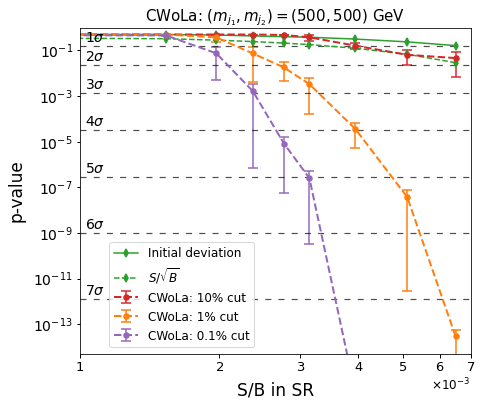

In [9]:
###################################################################################################################
#############################################    Make p-values plot    ############################################
###################################################################################################################

fig = plt.figure(figsize=(5*1.4,6))
ax = fig.add_subplot(1, 1, 1)

# Plot the initial p-value (i.e. 100% selection) and the naive expected significance
plt.errorbar(S_B_CW[:9], p0_median_100_per_cent[:9], xerr=None, yerr=None, 
             marker='d', color='C2', markersize=5, linestyle='-', linewidth=1.5, label=r'Initial deviation', 
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)
plt.errorbar(S_B_CW[:9], p0_expected[:9], xerr=None, yerr=None, 
             marker='d', color='C2', markersize=5, linestyle='--', linewidth=1.5, label=r'$S/\sqrt{B}$', 
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)

# Plot the p-value for the 10%, 1% and 0.1% cuts
plt.errorbar(S_B_CW[:9], p0_median_10_per_cent[:9], xerr=None, yerr=p0_mad_10_per_cent[:9], 
             marker='o', color='C3', markersize=5, linestyle='--', linewidth=2, label=r'CWoLa: 10% cut',
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)
plt.errorbar(S_B_CW[:9], p0_median_01_per_cent[:9], xerr=None, yerr=p0_mad_01_per_cent[:9], 
             marker='o', color='C1', markersize=5, linestyle='--', linewidth=2, label=r'CWoLa: 1% cut',
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)
plt.errorbar(S_B_CW[:9], p0_median_001_per_cent[:9], xerr=None, yerr=p0_mad_001_per_cent[:9], 
             marker='o', color='C4', markersize=5, linestyle='--', linewidth=2, label=r'CWoLa: 0.1% cut',
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)

# Plot lines with the fixed standard deviations
dashes = [5,6]
linestyles = [{'dashes':[5,6]},{'linestyle':'-'},{'linestyle':'-'},{'linestyle':'-'},{'linestyle':'-'}]

for sigma in range(1,8):
    ax.axhline(1-norm.cdf(sigma),dashes=dashes,color='black',linewidth=1.2, alpha=0.7)
    if sigma > 0:
        sigmastring = r'$' + str(sigma) + '\sigma$'
        ax.text(1.08*10**-3,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=14) 
ax.set_xscale('log')
ax.set_yscale('log')

# Options
plt.title(r'CWoLa: $(m_{j_{1}}, m_{j_{2}}) = (500, 500)$ GeV', fontsize=15)
plt.xlabel(r'S/B in SR', fontsize=17, labelpad=8)
plt.ylabel(r'p-value', fontsize=17, labelpad=8)
plt.legend(loc='lower left', bbox_to_anchor=(0.06,0.001), fontsize=12)
plt.xlim(xmin=10**-3, xmax = 7*10**-3)
plt.ylim(ymin=5*10**-15, ymax=1)
plt.tick_params(which='both', direction='out', length=3.5, width=1, labelsize=14)

# Set x-axis lscale and labels
plt.semilogx()
plt.gca().set_xticks([1*10**-3, 2*10**-3, 3*10**-3, 4*10**-3, 5*10**-3, 6*10**-3, 7*10**-3])
plt.gca().set_xticklabels([r'$1$', r'$2$', r'$3$', r'$4$', r'$5$', r'$6$', r'$7$'], fontsize=13)
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0), useMathText=True)
plt.gca().xaxis.offsetText.set_fontsize(12)

# Save figure
plt.savefig("/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/plots_efficiency/CWoLa_m500_pvalues_from_fit.pdf", 
            bbox_inches = 'tight', pad_inches = 0)

In [10]:
#######################################################################################################
##########################################   Save to file   ###########################################
#######################################################################################################    

save_path = '/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/CWoLa_signal_m500_efficiency_analysis/'

# Create dataset and classes to store important information
file_m500 = h5py.File(save_path + 'CWoLa_pvalues_from_fit_info_m500_corrected.hdf5', 'w')

# Save basic info
S_B_CW_tofile = file_m500.create_dataset('S_B', (len(S_B_CW), ), dtype='f8')
S_sqrt_B_CW_tofile = file_m500.create_dataset('S_sqrt_B', (len(S_sqrt_B_CW), ), dtype='f8')
p0_expected_tofile = file_m500.create_dataset('p0_expected', (len(p0_expected), ), dtype='f8')
p0_median_100_per_cent_tofile = file_m500.create_dataset('p0_median_100_per_cent', (len(p0_median_100_per_cent), ), dtype='f8')

# Save median info
p0_median_10_per_cent_tofile = file_m500.create_dataset('p0_median_10_per_cent', (len(p0_median_10_per_cent), ), dtype='f8')
p0_median_01_per_cent_tofile = file_m500.create_dataset('p0_median_01_per_cent', (len(p0_median_01_per_cent), ), dtype='f8')
p0_median_001_per_cent_tofile = file_m500.create_dataset('p0_median_001_per_cent', (len(p0_median_001_per_cent), ), dtype='f8')

# Save mad info
p0_mad_10_per_cent_tofile = file_m500.create_dataset('p0_mad_10_per_cent', (len(p0_mad_10_per_cent), ), dtype='f8')
p0_mad_01_per_cent_tofile = file_m500.create_dataset('p0_mad_01_per_cent', (len(p0_mad_01_per_cent), ), dtype='f8')
p0_mad_001_per_cent_tofile = file_m500.create_dataset('p0_mad_001_per_cent', (len(p0_mad_001_per_cent), ), dtype='f8')

# Fill dataset
S_B_CW_tofile[:] = S_B_CW
S_sqrt_B_CW_tofile[:] = S_sqrt_B_CW
p0_expected_tofile[:] = p0_expected
p0_median_100_per_cent_tofile[:] = p0_median_100_per_cent
p0_median_10_per_cent_tofile[:] = p0_median_10_per_cent
p0_median_01_per_cent_tofile[:] = p0_median_01_per_cent
p0_median_001_per_cent_tofile[:] = p0_median_001_per_cent
p0_mad_10_per_cent_tofile[:] = p0_mad_10_per_cent
p0_mad_01_per_cent_tofile[:] = p0_mad_01_per_cent
p0_mad_001_per_cent_tofile[:] = p0_mad_001_per_cent

file_m500.close()